# Clasifying the emotional state of users based on their activities
This notebook introduces some foundational machine learning and data science concepts by exploring the patterns between social media usage and emotional well-being **classification**.

## 1. Problem Definition
The increasing interaction with social media has raised concerns about its impact on users' emotional well-being. This project aims to understand how social media usage patterns can influence users' emotions

## 2. Data
The data is sourced from [Kaggle](https://www.kaggle.com/datasets/emirhanai/social-media-usage-and-emotional-well-being).

## 3. Evaluation
Our goal is to achieve 95% accuracy in predicting the emotional state of users. We will use accuracy as the metric of comparison between models, along with other metrics such as precision, recall, and F1-score to get a more comprehensive view of the model's performance

## 4. Features Dictionary
1. **User_ID:** Unique identifier for the user.
2. **Age:** Age of the user.
3. **Gender:** Gender of the user (Female, Male, Non-binary).
4. **Platform:** Social media platform used (e.g., Instagram, Twitter, Facebook, LinkedIn, Snapchat, Whatsapp, Telegram).
5. **Daily_Usage_Time (minutes):** Daily time spent on the platform in minutes.
6. **Posts_Per_Day:** Number of posts made per day.
7. **Likes_Received_Per_Day:** Number of likes received per day.
8. **Comments_Received_Per_Day:** Number of comments received per day.
9. **Messages_Sent_Per_Day:** Number of messages sent per day.
10. **Dominant_Emotion:** User's dominant emotional state during the day
    * Happiness
    * Sadness
    * Anger
    * Anxiety
    * Boredom
    * Neutral


In [1]:
# Regular EDA and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns

%matplotlib inline 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.multiclass import unique_labels

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

# Print last updated
import time
print(f"Last updated: {time.asctime()}")

Last updated: Sat May 25 06:41:58 2024


## 1. Load Data

In [2]:
df_train = pd.read_csv('/kaggle/input/social-media-dataset/train.csv')
df_val = pd.read_csv('/kaggle/input/social-media-dataset/val.csv')

df = pd.concat([df_train, df_val], axis=0)
df.head()

,User_ID,Age,Gender,Platform,Daily_Usage_Time (minutes),Posts_Per_Day,Likes_Received_Per_Day,Comments_Received_Per_Day,Messages_Sent_Per_Day,Dominant_Emotion
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,25.0,Female,Instagram,120.0,3.0,45.0,10.0,12.0,Happiness
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,30.0,Male,Twitter,90.0,5.0,20.0,25.0,30.0,Anger
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Exploration

### 2.1. Analysis of people's sentiment based on likes received per day

### Visualization

The following graph ilustrates the sentiment of people based on the likes received per day

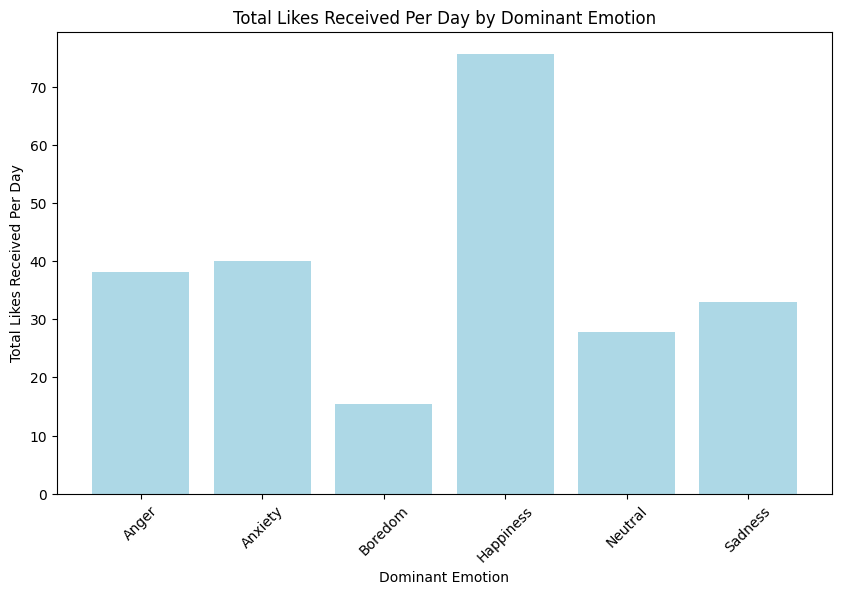

In [3]:
# Agrupar por Dominant_Emotion y sumar Likes_Received_Per_Day
grouped_likes = df_train.groupby('Dominant_Emotion')['Likes_Received_Per_Day'].mean().reset_index()

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(grouped_likes['Dominant_Emotion'], grouped_likes['Likes_Received_Per_Day'], color='lightblue')

# Personalizar la gráfica
plt.title('Total Likes Received Per Day by Dominant Emotion')
plt.xlabel('Dominant Emotion')
plt.ylabel('Total Likes Received Per Day')
plt.xticks(rotation=45)
plt.show()

### Results

> As observed, it is concerning that people tend to feel happiness when they receive more likes, but experience a sense of emptiness when they do not

## 2.2. Analysis of time spent per platform

### Visualization

The following graph ilustrates the distribution of time spent per platform

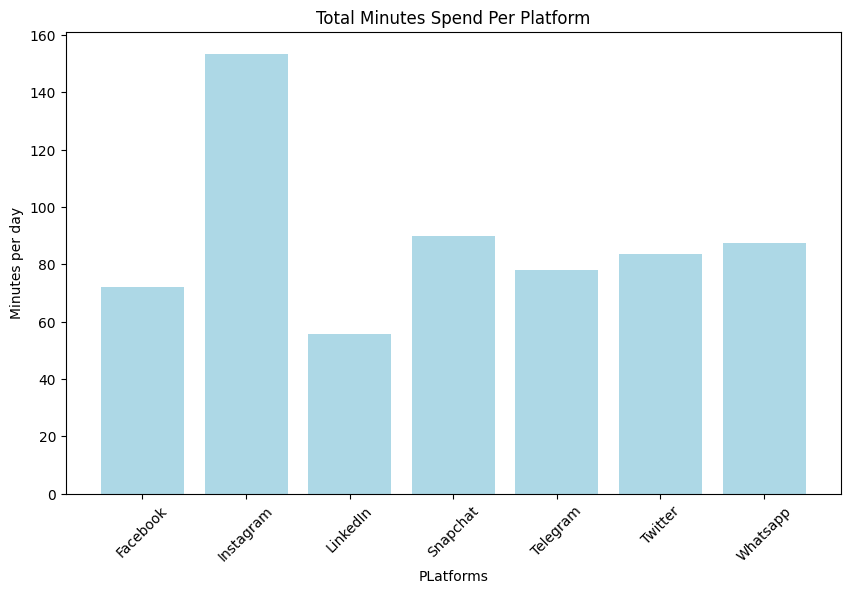

In [4]:
# Agrupar por Dominant_Emotion y sumar Likes_Received_Per_Day
grouped_likes = df_train.groupby('Platform')['Daily_Usage_Time (minutes)'].mean().reset_index()

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(grouped_likes['Platform'], grouped_likes['Daily_Usage_Time (minutes)'], color='lightblue')

# Personalizar la gráfica
plt.title('Total Minutes Spend Per Platform')
plt.xlabel('PLatforms')
plt.ylabel('Minutes per day')
plt.xticks(rotation=45)
plt.show()

### Results 

> As we can see, the most important application to users is **Instagram** with a average of 150 minutes per day.

## 2.3. Analysis of time spent on social media by gender

### Visualization

The following graph ilustrates the time spent on social media based on gender

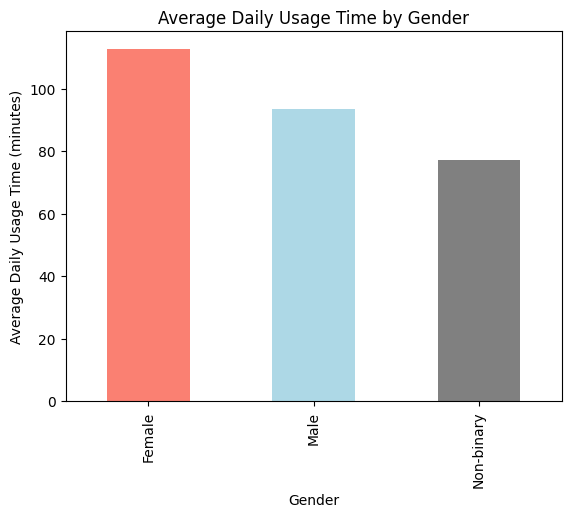

In [5]:


# Convertir la columna 'Age' a numérico, forzando errores a NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Eliminar filas con valores numéricos en 'Gender'
df = df[~df['Gender'].apply(lambda x: isinstance(x, (int, float)))]

# Calcular el promedio de uso diario por género
mean_usage_by_gender = df.groupby('Gender')['Daily_Usage_Time (minutes)'].mean().reset_index()

# Renombrar las columnas para mayor claridad
mean_usage_by_gender.columns = ['Gender', 'Average_Daily_Usage_Time']

# Definir los colores para cada género
colors = {
    'Female': 'salmon',
    'Male': 'lightblue',
    'Non-binary': 'gray'
}

# Crear la lista de colores para las barras
bar_colors = [colors[gender] for gender in mean_usage_by_gender['Gender']]

# Graficar los resultados
mean_usage_by_gender.plot(kind='bar', x='Gender', y='Average_Daily_Usage_Time', legend=False, color=bar_colors)
plt.xlabel('Gender')
plt.ylabel('Average Daily Usage Time (minutes)')
plt.title('Average Daily Usage Time by Gender')
plt.show()

### Results

> In the last graphic, we can see that the group that uses social media the most is **Females**

## 2.4. Ouliers analysis by column with respect to dominant emotion

### Visualization

The following graph ilustrates the outliers for each column respect to the dominant emotion

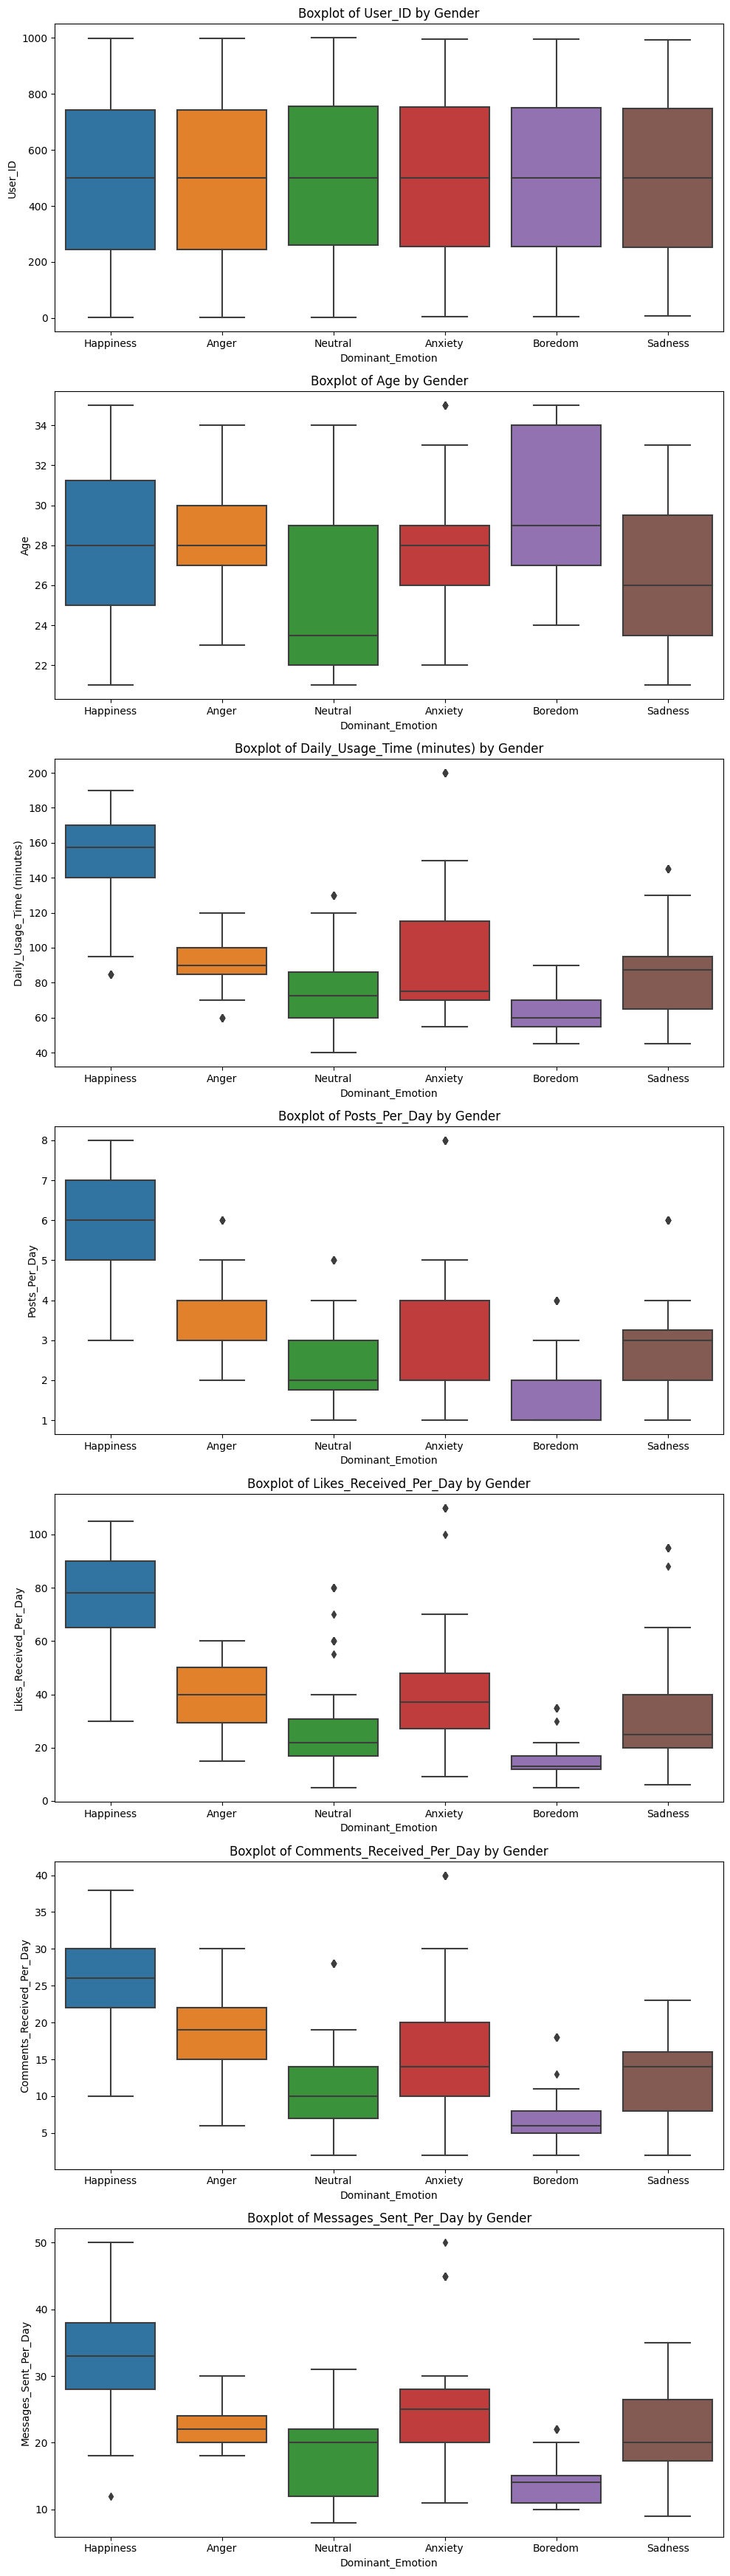

In [6]:
# Identificar las columnas numéricas
numeric_columns = df_train.select_dtypes(include='number').columns

# Crear subplots
num_plots = len(numeric_columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 5 * num_plots))

# Si solo hay una columna numérica, axes no será una lista, por lo que la convertimos en una lista
if num_plots == 1:
    axes = [axes]

# Crear un diagrama de caja para cada columna numérica
for ax, column in zip(axes, numeric_columns):
    sns.boxplot(x='Dominant_Emotion', y=column, data=df_train, ax=ax)
    ax.set_xlabel('Dominant_Emotion')
    ax.set_ylabel(column)
    ax.set_title(f'Boxplot of {column} by Gender')

plt.tight_layout()
plt.show()

## 3. Data Processing

### 3.1 Handing outliers values

In [7]:
df.drop(columns=['User_ID'], inplace=True)

In [8]:
df_numeric = df.select_dtypes(include=np.number)

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

cut_off = 1.5 * IQR
lower_bound = Q1 - cut_off
upper_bound = Q3 + cut_off

while True:
    for column in df_numeric.columns:
        is_outlier_lower = df[column] < lower_bound[column]
        is_outlier_upper = df[column] > upper_bound[column]
        median = df_numeric[column].median()
        df.loc[is_outlier_lower | is_outlier_upper, column] = median

    Q1 = df_train[df_numeric.columns].quantile(0.25)
    Q3 = df_train[df_numeric.columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_remaining = ((df[df_numeric.columns] < lower_bound) | (df[df_numeric.columns] > upper_bound)).sum()
    
    if outliers_remaining.sum() == 0:
        break

print('Número total de outliers reemplazados:')
print(outliers_remaining)

Número total de outliers reemplazados:
Age                           0
Daily_Usage_Time (minutes)    0
Posts_Per_Day                 0
Likes_Received_Per_Day        0
Comments_Received_Per_Day     0
Messages_Sent_Per_Day         0
dtype: int64


### 3.2. Handing missing and normalize values

In [9]:
df.isnull().sum()

Age                           0
Gender                        0
Platform                      0
Daily_Usage_Time (minutes)    0
Posts_Per_Day                 0
Likes_Received_Per_Day        0
Comments_Received_Per_Day     0
Messages_Sent_Per_Day         0
Dominant_Emotion              0
dtype: int64

In [10]:
df = df.dropna()

if df.isnull().sum().sum() != 0:
    print("Existen valores NaN en el DataFrame después de eliminar las filas vacías.")
else:
    print("No hay valores NaN en el DataFrame.")

df_numeric = df.select_dtypes(include=np.number)

scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)

df[df_numeric.columns] = df_normalized

print("Valores NaN después de la normalización:")
print(df.isnull().sum())

No hay valores NaN en el DataFrame.
Valores NaN después de la normalización:
Age                           0
Gender                        0
Platform                      0
Daily_Usage_Time (minutes)    0
Posts_Per_Day                 0
Likes_Received_Per_Day        0
Comments_Received_Per_Day     0
Messages_Sent_Per_Day         0
Dominant_Emotion              0
dtype: int64


## 3.3. Convert string to categories

In [11]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147 entries, 1 to 293
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         1147 non-null   float64 
 1   Gender                      1147 non-null   category
 2   Platform                    1147 non-null   category
 3   Daily_Usage_Time (minutes)  1147 non-null   float64 
 4   Posts_Per_Day               1147 non-null   float64 
 5   Likes_Received_Per_Day      1147 non-null   float64 
 6   Comments_Received_Per_Day   1147 non-null   float64 
 7   Messages_Sent_Per_Day       1147 non-null   float64 
 8   Dominant_Emotion            1147 non-null   category
dtypes: category(3), float64(6)
memory usage: 66.9 KB


## 3.4. Codyfing categorical variables

In [12]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes

### 3.5. Correlation matrix
> Now that we have encoded our categorical variables, we can generate a correlation matrix to identify the impact that independent variables have on the dependent variable. 

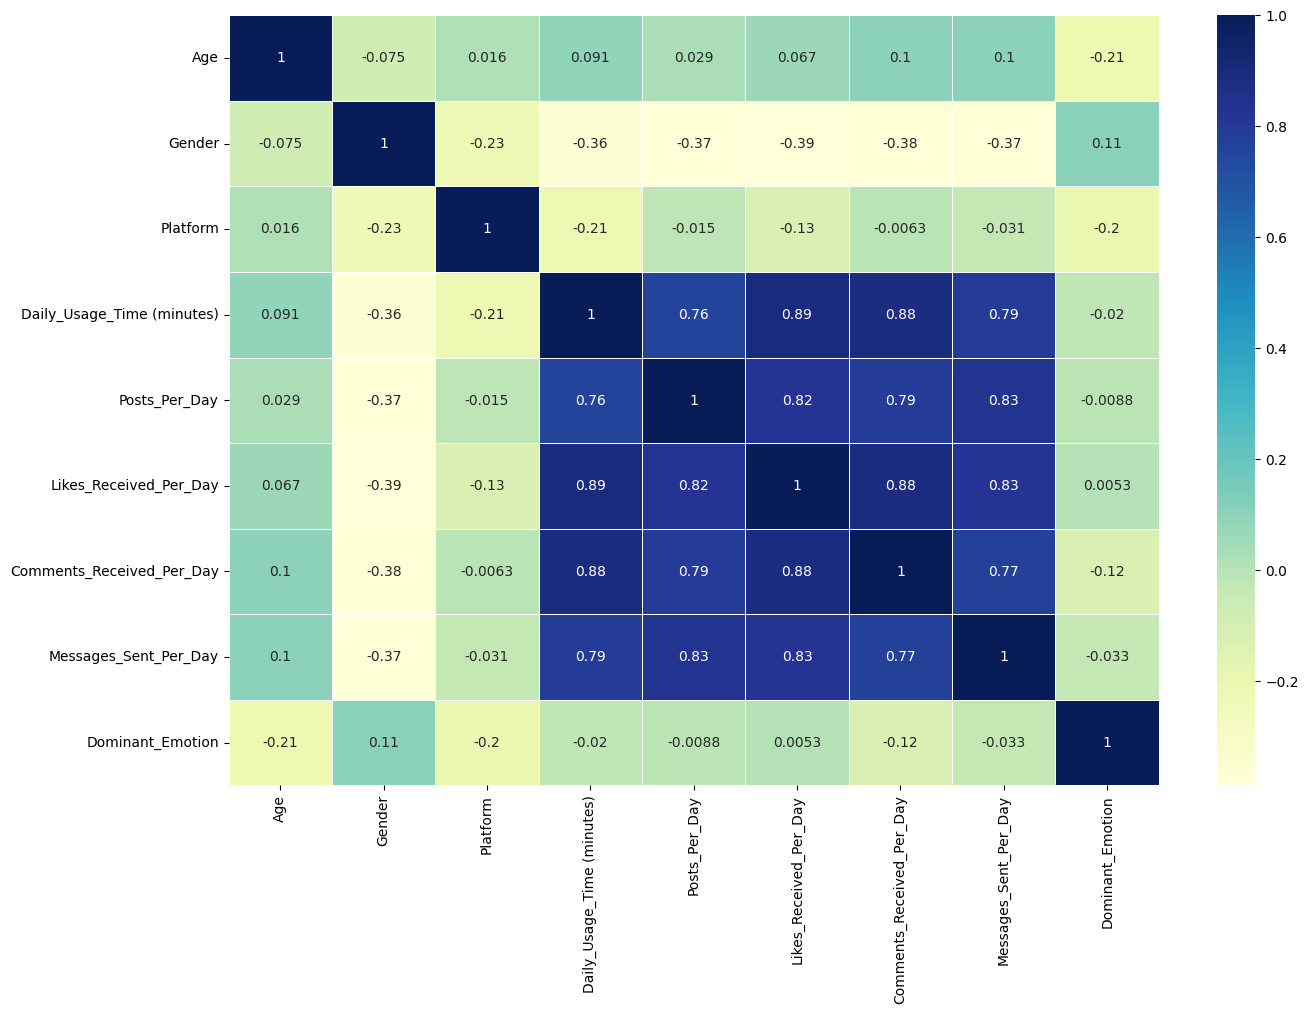

In [13]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix,
           annot=True,
           linewidths=0.5,
           cmap='YlGnBu');

> As we can see, the independent variables that appear to have the greatest impact are **Daily_Usage_Time**, **Posts_Per_Day**, **Likes_Received_Per_Day**, **Comments_Received_Per_Day** and **Messages_Sent_Per_Day**.

## 4. Modeling

### Model Choices

In this project we are going to implement six different classification models:

1. **KNN (K-Nearest Neighbors)**
   * KNN is a simple and versatile algorithm for classification tasks
   * It can capture complex patterns in the data
2. **Logistic Regression**
   * Logistic Regression is a classic and widely used model for binary classification problems
   * It provides a probabilistic interpretation of the relationship between independent variables and the dependent variable
5. **Random Forest**
   * Random Forest is an ensemble algorithm that combines multiple decision trees to improve accuracy and reduce overfitting
   * It is robust against outliers and missing data
7. **Support Vector Machine (SVM)**
   * SVM has good generalization capabilities and is resistant to overfitting
9. **Decision Trees**
    * They can handle numerical and categorical data without extensive preprocessing
11. **XGBoost**
    * XGBoost is an optimized implementation of gradient-boosting algorithms
    * It provides high accuracy and speed in predictions

In [14]:
X = df.drop('Dominant_Emotion', axis=1) 
y = df.Dominant_Emotion

# Contar las instancias de cada clase
class_counts = pd.Series(y).value_counts()

print("Distribución de clases usando pandas:")
print(class_counts)

# Identificar la clase con menos miembros
min_class = class_counts.idxmin()
min_count = class_counts.min()

print(f"\nLa clase con menos miembros es: {min_class} con {min_count} instancias")

# Eliminar la clase con menos miembros de tus datos
X = X[y != min_class]
y = y[y != min_class]

# Verificar la distribución actualizada
class_counts_filtered = pd.Series(y).value_counts()
print("\nDistribución de clases después de eliminar la clase con menos miembros:")
print(class_counts_filtered)

X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2,
                                                    random_state=42)

Distribución de clases usando pandas:
Dominant_Emotion
5    230
4    228
2    201
6    185
3    158
1    144
0      1
Name: count, dtype: int64

La clase con menos miembros es: 0 con 1 instancias

Distribución de clases después de eliminar la clase con menos miembros:
Dominant_Emotion
5    230
4    228
2    201
6    185
3    158
1    144
Name: count, dtype: int64


## 4.1. Model Comparison

In [15]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "Support Vector Machine": SVC(),
          "Decision Trees": DecisionTreeClassifier(),
          "XGBoost": GradientBoostingClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = round(model.score(X_test, y_test),4)
    return model_scores

model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)


# Convertir el diccionario en un DataFrame de pandas
scores_df = pd.DataFrame(list(model_scores.items()), columns=['Modelo', 'Precisión'])

from tabulate import tabulate
# Formatear y mostrar el DataFrame usando tabulate
print(tabulate(scores_df, headers='keys', tablefmt='pretty', showindex=False))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


+------------------------+-----------+
|         Modelo         | Precisión |
+------------------------+-----------+
|          KNN           |  0.9609   |
|  Logistic Regression   |  0.5783   |
|     Random Forest      |  0.9565   |
| Support Vector Machine |  0.5957   |
|     Decision Trees     |  0.9478   |
|        XGBoost         |  0.9478   |
+------------------------+-----------+


> Now, we have six different classifier, between these we gonna select three better to tuning, this models were **KNN**, **Random Forest**, **Decision Trees** and **XGBoost**

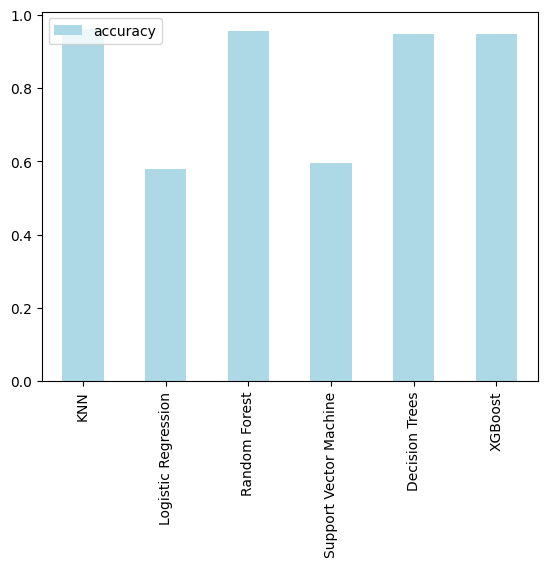

In [16]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar(color='lightblue');

## 4.2. Hyperparameter tuning (RadomizedSearchCV) and cross-validation

In [17]:
# Different LogisticRegression hyperparameters
knn_grid = {
    'n_neighbors' :np.arange(2, 30, 1)
}

# Different RandomForestClassifier hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [None, 3, 5, 10, 20, 30],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "bootstrap": [True, False]
}

# Different DecisionTreeClassifier hyperparameters
dt_grid = {
    "max_depth": [None, 2, 3, 5, 10, 20],
    "min_samples_split": np.arange(2, 15, 2),
    "min_samples_leaf": np.arange(1, 50, 5),
    "criterion": ["gini", "entropy"]
}

# Different XGBoostClassifier hyperparameters
gbc_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['sqrt', 'log2']
}

In [18]:
%%time 

# Configuración de RandomizedSearchCV para LogisticRegression
rs_knn = RandomizedSearchCV(KNeighborsClassifier(),
                                param_distributions=knn_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True,
                                n_jobs=-1)

# Configuración de RandomizedSearchCV para RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,
                           n_jobs=-1)

# Configuración de RandomizedSearchCV para DecisionTreeClassifier
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dt_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,
                           n_jobs=-1)

# Configuración de RandomizedSearchCV para XGBoostClassifier
rs_gbc = RandomizedSearchCV(GradientBoostingClassifier(),
                            param_distributions=gbc_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True,
                            n_jobs=-1)

# Setup random seed
np.random.seed(42)
rs_knn.fit(X_train, y_train);
rs_rf.fit(X_train, y_train);
rs_dt.fit(X_train, y_train);
rs_gbc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 4.96 s, sys: 327 ms, total: 5.29 s
Wall time: 1min 52s


In [19]:
np.random.seed(42)
scores = {
    "KNN": rs_knn.best_estimator_.score(X_test, y_test),
    "Random Forest": rs_rf.best_estimator_.score(X_test, y_test),
    "Decision Tree": rs_dt.best_estimator_.score(X_test, y_test),
    "Gradient Boosting": rs_gbc.best_estimator_.score(X_test, y_test)
}

table = []
for model, score in scores.items():
    table.append([model, score])

print(tabulate(table, headers=["Model", "Score"], tablefmt="pretty"))

+-------------------+--------------------+
|       Model       |       Score        |
+-------------------+--------------------+
|        KNN        | 0.9652173913043478 |
|   Random Forest   | 0.9608695652173913 |
|   Decision Tree   | 0.9304347826086956 |
| Gradient Boosting | 0.9521739130434783 |
+-------------------+--------------------+


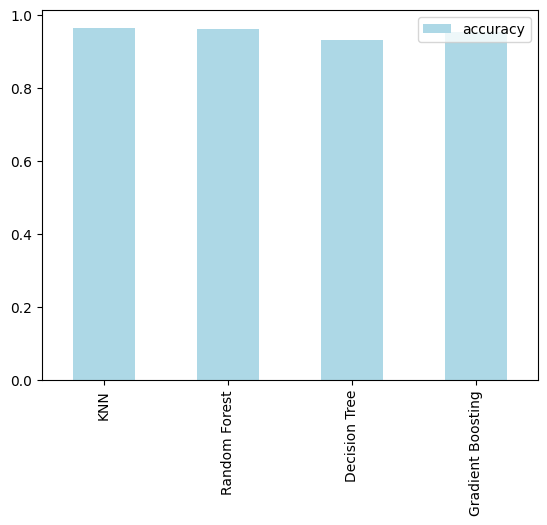

In [20]:
model_compare = pd.DataFrame(scores, index=['accuracy'])
model_compare.T.plot.bar(color='lightblue');

> Now, we really sure that the best model is KNN.

## Evaluation a classification model 
* ROC curve and AUC score - [`RocCurveDisplay()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) 
     `sklearn.metrics.RocCurveDisplay()`.
* Confusion matrix - [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* Classification report - [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* Precision - [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* Recall - [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* F1-score - [`f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

### ROC Curve and AUC Scores

<Figure size 800x600 with 0 Axes>

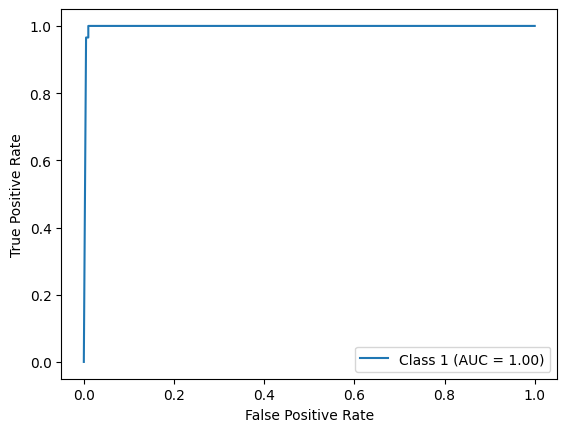

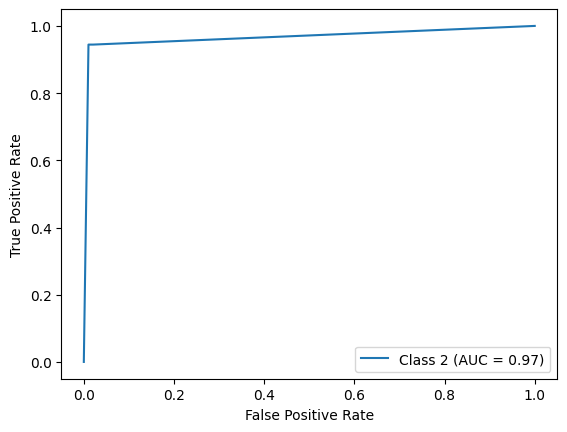

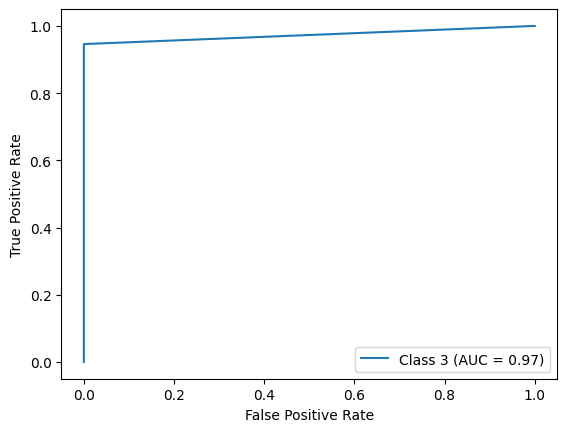

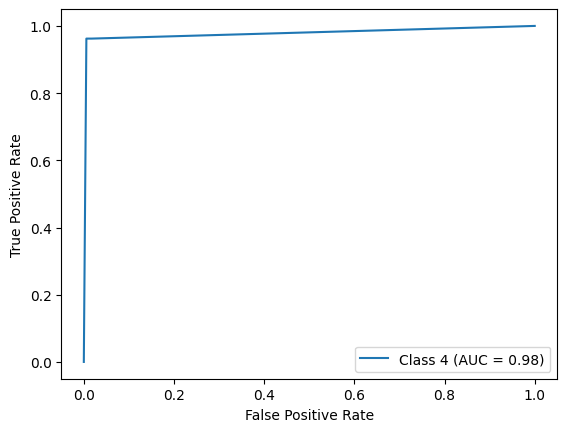

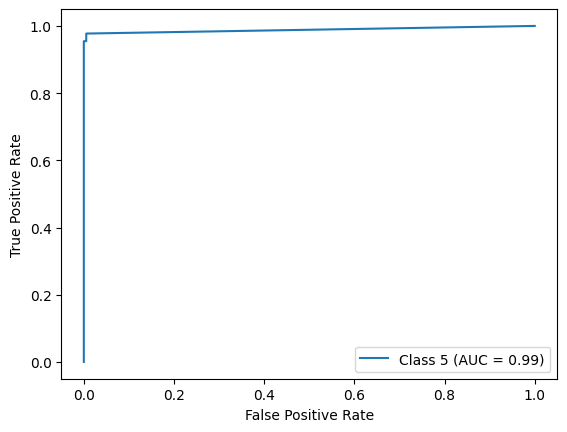

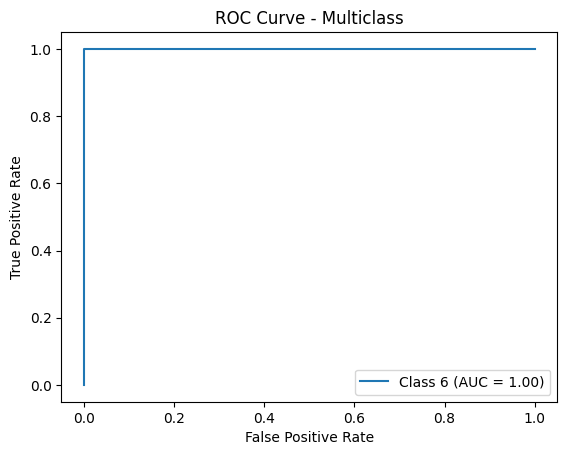

In [21]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Binarizar las etiquetas
y_test_bin = label_binarize(y_test, classes=rs_knn.classes_)

# Obtener las probabilidades predictivas
y_score = rs_knn.predict_proba(X_test)

# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(rs_knn.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Trazar la curva ROC para cada clase
plt.figure(figsize=(8, 6))

for i in range(len(rs_knn.classes_)):
    display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {rs_knn.classes_[i]}')
    display.plot()

#plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random guess')
plt.title('ROC Curve - Multiclass')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

> An AUC (Area Under the Curve) of 1.0 indicates that the model has perfect performance in distinguishing between positive and negative classes. This means that the model correctly classifies all instances without making any errors

### Confusion matrix

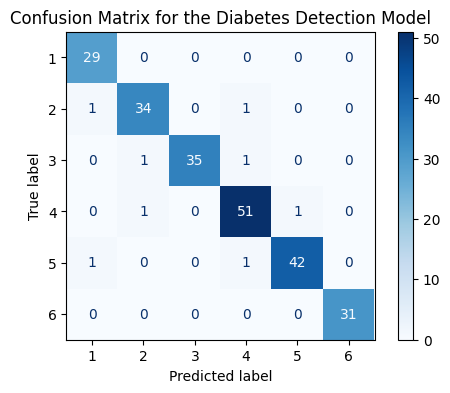

In [22]:
y_preds = rs_knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_preds)
class_names = unique_labels(y_test, y_preds)  # Get unique class labels

# Change figure size and increase dpi for better resolution
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

# Choose a colormap for visualization (e.g., 'viridis', 'plasma', 'coolwarm')
cmap = 'Blues'

# Create ConfusionMatrixDisplay object (passing class labels)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)

# Customize color scale using the "cmap" parameter
display.plot(ax=ax, cmap=cmap)

# Set the plot title using the axes object
ax.set(title='Confusion Matrix for the Diabetes Detection Model')

# Remove gridlines
ax.grid(False)  # Turn off gridlines

plt.show()

### Classification report

In [23]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        29
           2       0.94      0.94      0.94        36
           3       1.00      0.95      0.97        37
           4       0.94      0.96      0.95        53
           5       0.98      0.95      0.97        44
           6       1.00      1.00      1.00        31

    accuracy                           0.97       230
   macro avg       0.97      0.97      0.97       230
weighted avg       0.97      0.97      0.97       230



* **High Precision and Recall:** The model has high precision and recall for both classes, with particularly notable perfect precision for the positive class (1.00) and perfect recall for the negative class (1.00). This indicates that the model is very reliable in its predictions and rarely makes errors.
* **High F1-Score:** The high F1-scores for both classes (0.99 for the negative class and 0.97 for the positive class) indicate that the model maintains a good balance between precision and recall.
* **Consistent Performance:** The macro and weighted averages indicate consistent and solid performance across both classes, which is especially important in cases of class imbalance.

In [24]:
#check best hiperparameters
rs_knn.best_params_

{'n_neighbors': 3}

> Now we init best model with best hyperparameters

In [25]:
np.random.seed(42)

model_knn = KNeighborsClassifier(n_neighbors=3)

model_knn.fit(X_train, y_train)

model_knn.score(X_test, y_test)

0.9652173913043478

### Cross validation metrics
> The previous results were very good, which raises the question of whether the model might be overfitted. Therefore, an analysis of the metrics will be performed using cross-validation to obtain a more robust value.

In [26]:
# Cross-validated accuracy score
cv_acc = cross_val_score(model_knn,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy") # accuracy as scoring
cv_acc = np.mean(cv_acc)
cv_acc

0.9703170685399659

In [27]:
# Cross-validated precision score

scorer = make_scorer(precision_score, average='micro')

cv_precision = cross_val_score(model_knn,
                               X,
                               y, 
                               cv=5,
                               scoring=scorer)

cv_precision = np.mean(cv_precision)
cv_precision

0.9703170685399659

In [28]:
# Cross-validated recall score
# Definir la métrica de recall para problemas multiclase
scorer = make_scorer(recall_score, average='micro')

# Calcular el recall utilizando cross-validation
cv_recall = cross_val_score(model_knn, X, y, cv=10, scoring=scorer)

# Calcular el recall promedio
cv_recall = np.mean(cv_recall)
cv_recall

0.9701983218916859

In [29]:
# Cross-validated F1 score
# Definir la métrica de F1-score para problemas multiclase
scorer = make_scorer(f1_score, average='micro')

# Calcular el F1-score utilizando cross-validation
cv_f1 = cross_val_score(model_knn, X, y, cv=10, scoring=scorer)

# Calcular el F1-score promedio
cv_f1 = np.mean(cv_f1)
cv_f1

0.9701983218916859

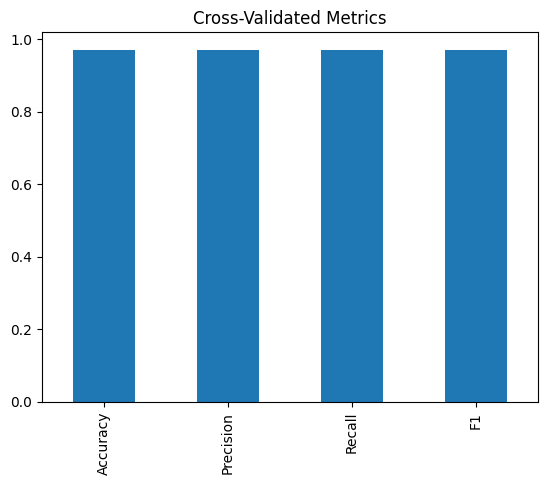

In [30]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                            index=[0])

cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

## Conclusions

> In conclusion, we successfully designed an optimal **KNN model**, achieving a **precision of 97%** in cross-validation. This indicates a high level of accuracy when applied in real-world scenarios. With this model, we can more accurately determine people's current mood, which is significantly influenced by the excessive use and integration of social media in our lives.
